In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/temporal-fusion-transformer/batch_14.parquet
/kaggle/input/temporal-fusion-transformer/batch_21.parquet
/kaggle/input/temporal-fusion-transformer/batch_20.parquet
/kaggle/input/temporal-fusion-transformer/batch_03.parquet
/kaggle/input/temporal-fusion-transformer/batch_07.parquet
/kaggle/input/temporal-fusion-transformer/batch_18.parquet
/kaggle/input/temporal-fusion-transformer/batch_12.parquet
/kaggle/input/temporal-fusion-transformer/batch_11.parquet
/kaggle/input/temporal-fusion-transformer/batch_10.parquet
/kaggle/input/temporal-fusion-transformer/batch_08.parquet
/kaggle/input/temporal-fusion-transformer/batch_09.parquet
/kaggle/input/temporal-fusion-transformer/batch_06.parquet
/kaggle/input/temporal-fusion-transformer/batch_15.parquet
/kaggle/input/temporal-fusion-transformer/batch_17.parquet
/kaggle/input/temporal-fusion-transformer/batch_02.parquet
/kaggle/input/temporal-fusion-transformer/batch_05.parquet
/kaggle/input/temporal-fusion-transformer/batch_16.parqu

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 1. Đọc dữ liệu từ các file parquet
# ---------------------------
path = "/kaggle/input/temporal-fusion-transformer"
files = [f for f in os.listdir(path) if f.endswith('.parquet')]

dfs = []
for file in files:
    full_path = os.path.join(path, file)
    df = pd.read_parquet(full_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [4]:
# Lớp TimeSeriesDataset để tạo các chuỗi dữ liệu thời gian
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len=432, pred_len=144):
        self.input_len = input_len  # Độ dài chuỗi đầu vào (432 × 10 phút = 72 giờ)
        self.pred_len = pred_len    # Độ dài chuỗi dự báo (144 × 10 phút = 24 giờ)
        self.sequences = self.create_sequences(data)
    
    def create_sequences(self, data):
        sequences = []
        total_len = self.input_len + self.pred_len
        for i in range(len(data) - total_len + 1):
            input_seq = data[i:i + self.input_len]
            target_seq = data[i + self.input_len:i + total_len]
            sequences.append((input_seq, target_seq))
        return sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [5]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error
import joblib

class XGBoostModel:
    def __init__(self, task_type='classification', params=None, num_round=100):
        self.task_type = task_type
        self.num_round = num_round

        # Thiết lập tham số mặc định nếu không có
        if params is None:
            if task_type == 'classification':
                self.params = {
                    'objective': 'binary:logistic',
                    'eval_metric': 'logloss',
                    'max_depth': 6,
                    'eta': 0.3
                }
            elif task_type == 'regression':
                self.params = {
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'max_depth': 6,
                    'eta': 0.3
                }
            else:
                raise ValueError("task_type phải là 'classification' hoặc 'regression'")
        else:
            self.params = params

        self.model = None

    def train(self, X_train, y_train):
        dtrain = xgb.DMatrix(X_train, label=y_train)
        self.model = xgb.train(self.params, dtrain, num_boost_round=self.num_round)

    def predict(self, X):
        dmatrix = xgb.DMatrix(X)
        y_pred = self.model.predict(dmatrix)
        if self.task_type == 'classification':
            return (y_pred > 0.5).astype(int)
        return y_pred

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        if self.task_type == 'classification':
            acc = accuracy_score(y_test, y_pred)
            return {'accuracy': acc}
        elif self.task_type == 'regression':
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            return {'rmse': rmse}

    def save_model(self, path):
        self.model.save_model(path)

    def load_model(self, path):
        self.model = xgb.Booster()
        self.model.load_model(path)

In [6]:
# Hàm huấn luyện mô hình
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Hàm đánh giá mô hình
def evaluate_model(model, dataloader, criterion, device, scaler=None):
    model.eval()
    mse_list = []
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            y_pred_np = y_pred.cpu().numpy()
            y_true_np = y.cpu().numpy()
            if scaler:
                y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, y_pred_np.shape[-1])).reshape(y_pred_np.shape)
                y_true_np = scaler.inverse_transform(y_true_np.reshape(-1, y_true_np.shape[-1])).reshape(y_true_np.shape)
            mse = mean_squared_error(y_true_np.flatten(), y_pred_np.flatten())
            mse_list.append(mse)
    return total_loss / len(dataloader), np.mean(mse_list)


In [7]:
# Hàm huấn luyện và lưu mô hình cho 100 Square id ngẫu nhiên
def train_and_save_models(batch_folder, output_dir="models", input_len=432, pred_len=144, num_epochs=10, num_ids=100):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity', 'Internet traffic activity']
    
    # Lấy danh sách file batch
    batch_files = [f for f in sorted(os.listdir(batch_folder)) if f.endswith(".parquet")]
    if not batch_files:
        print("Không tìm thấy file parquet trong thư mục")
        return
    
    # Chọn 100 Square id ngẫu nhiên từ batch đầu tiên
    first_batch_path = os.path.join(batch_folder, batch_files[0])
    print(f"Đang đọc batch đầu tiên: {batch_files[0]}")
    first_df = pd.read_parquet(first_batch_path)
    unique_square_ids = first_df['Square id'].unique()
    if len(unique_square_ids) < num_ids:
        print(f"Chỉ có {len(unique_square_ids)} Square id, chọn tất cả")
        selected_square_ids = unique_square_ids
    else:
        selected_square_ids = np.random.choice(unique_square_ids, size=num_ids, replace=False)
    
    print(f"Đã chọn {len(selected_square_ids)} Square id để huấn luyện")
    
    # Gộp dữ liệu từ tất cả batch cho các Square id được chọn
    all_data = []
    for batch_file in batch_files:
        batch_path = os.path.join(batch_folder, batch_file)
        print(f"Đang đọc {batch_file}")
        df = pd.read_parquet(batch_path)
        df['Time Interval'] = pd.to_datetime(df['Time Interval'], unit='ms')
        # Lọc chỉ các Square id được chọn
        df = df[df['Square id'].isin(selected_square_ids)]
        all_data.append(df)
    
    # Gộp tất cả batch thành một DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df = combined_df.sort_values(['Square id', 'Time Interval'])
    
    # Huấn luyện mô hình cho từng Square id
    for square_id in selected_square_ids:
        print(f"\n=== Huấn luyện cho Square id {square_id} ===")
        group = combined_df[combined_df['Square id'] == square_id].sort_values('Time Interval')
        data = group[features].values
        
        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        
        # Tạo dataset
        dataset = TimeSeriesDataset(data, input_len, pred_len)
        if len(dataset) < 10:
            print(f"Bỏ qua Square id {square_id}: không đủ dữ liệu ({len(dataset)} chuỗi)")
            continue
        
        # Chia tập huấn luyện và kiểm tra
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta

def train_and_save_xgb_models(batch_folder, output_dir="models_xgb", num_ids=100):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity']
    target = 'Internet traffic activity'

    batch_files = [f for f in sorted(os.listdir(batch_folder)) if f.endswith(".parquet")]
    if not batch_files:
        print("❌ Không tìm thấy file parquet trong thư mục")
        return

    # Chọn 100 square ID ngẫu nhiên
    first_df = pd.read_parquet(os.path.join(batch_folder, batch_files[0]))
    unique_square_ids = first_df['Square id'].unique()
    if len(unique_square_ids) < num_ids:
        selected_square_ids = unique_square_ids
    else:
        selected_square_ids = np.random.choice(unique_square_ids, size=num_ids, replace=False)

    print(f"✅ Đã chọn {len(selected_square_ids)} Square ID để huấn luyện")

    # Gộp dữ liệu
    all_data = []
    for file in batch_files:
        df = pd.read_parquet(os.path.join(batch_folder, file))
        df['Time Interval'] = pd.to_datetime(df['Time Interval'], unit='ms')
        df = df[df['Square id'].isin(selected_square_ids)]
        all_data.append(df)

    combined_df = pd.concat(all_data).sort_values(['Square id', 'Time Interval'])

    results = []
    for square_id in selected_square_ids:
        print(f"\n🚀 Huấn luyện cho Square ID {square_id}")
        df_sq = combined_df[combined_df['Square id'] == square_id]
        if len(df_sq) < 50:
            print(f"⚠ Bỏ qua Square ID {square_id}: không đủ dữ liệu ({len(df_sq)} bản ghi)")
            continue

        X = df_sq[features].values
        y = df_sq[target].values

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        split_idx = int(0.8 * len(X_scaled))
        X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        params = {'objective': 'reg:squarederror', 'max_depth': 3, 'eta': 0.1, 'seed': 42}
        model = xgb.train(params, dtrain, num_boost_round=100,
                          evals=[(dval, 'eval')],
                          early_stopping_rounds=10, verbose_eval=False)

        # Lưu model + scaler
        model.save_model(os.path.join(output_dir, f"xgb_square_{square_id}.json"))
        with open(os.path.join(output_dir, f"scaler_square_{square_id}.pkl"), 'wb') as f:
            pickle.dump(scaler, f)

        # Đánh giá
        y_pred = model.predict(dval)
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        print(f"[Square ID {square_id}] MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
        results.append({'Square ID': square_id, 'MSE': mse, 'MAE': mae, 'R2': r2})

    # Tổng kết
    if results:
        results_df = pd.DataFrame(results)
        print("\n📊 KẾT QUẢ HUẤN LUYỆN")
        print(results_df.to_string(index=False))
        results_df.to_csv(os.path.join(output_dir, "xgb_results_summary.csv"), index=False)
    else:
        print("⚠ Không huấn luyện được mô hình nào")

def predict_xgb_random(batch_folder, model_dir="models_xgb"):
    features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity']

    batch_files = [f for f in sorted(os.listdir(batch_folder)) if f.endswith(".parquet")]
    all_data = []
    for file in batch_files:
        df = pd.read_parquet(os.path.join(batch_folder, file))
        df['Time Interval'] = pd.to_datetime(df['Time Interval'], unit='ms')
        all_data.append(df)

    if not all_data:
        print("❌ Không tìm thấy dữ liệu")
        return

    df = pd.concat(all_data)
    df['Day of Week'] = df['Time Interval'].dt.dayofweek
    df['Hour'] = df['Time Interval'].dt.hour

    # Chọn ngẫu nhiên Square ID
    square_ids = df['Square id'].unique()
    square_id = np.random.choice(square_ids)
    df_sq = df[df['Square id'] == square_id]

    # Chọn ngẫu nhiên thời điểm
    row = df_sq.sample(1).iloc[0]
    hour = row['Hour']
    day_idx = row['Day of Week']
    latest_time = row['Time Interval']

    model_path = os.path.join(model_dir, f"xgb_square_{square_id}.json")
    scaler_path = os.path.join(model_dir, f"scaler_square_{square_id}.pkl")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"❌ Không tìm thấy model/scaler cho Square ID {square_id}")
        return

    model = xgb.Booster()
    model.load_model(model_path)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    X_input = row[features].values.reshape(1, -1)
    X_scaled = scaler.transform(X_input)
    y_pred = model.predict(xgb.DMatrix(X_scaled))[0]

    days = ['Thứ hai', 'Thứ ba', 'Thứ tư', 'Thứ năm', 'Thứ sáu', 'Thứ bảy', 'Chủ nhật']
    print(f"\n✅ Dự báo cho Square ID {square_id} tại {days[day_idx]} {latest_time.strftime('%Y-%m-%d %H:%M')}")
    print(f"Internet traffic activity dự báo: {y_pred:.2f} MB")

def main():
    batch_folder = "/kaggle/input/temporal-fusion-transformer"  # Đổi đường dẫn nếu cần
    model_dir = "models_xgb"

    # Huấn luyện nếu chưa có model
    if not os.path.exists(model_dir) or not any(f.endswith('.json') for f in os.listdir(model_dir)):
        print("🚀 Bắt đầu huấn luyện mô hình...")
        train_and_save_xgb_models(batch_folder, model_dir)

    # Dự báo ngẫu nhiên
    while True:
        predict_xgb_random(batch_folder, model_dir)
        cont = input("\nTiếp tục dự báo? (y/n): ")
        if cont.lower() != 'y':
            break

if __name__ == "__main__":
    main()


🚀 Bắt đầu huấn luyện mô hình...
✅ Đã chọn 100 Square ID để huấn luyện

🚀 Huấn luyện cho Square ID 5099
[Square ID 5099] MSE: 151.74, MAE: 8.94, R2: 0.52

🚀 Huấn luyện cho Square ID 800
[Square ID 800] MSE: 8.62, MAE: 2.63, R2: -4841.45

🚀 Huấn luyện cho Square ID 4901
[Square ID 4901] MSE: 0.44, MAE: 0.46, R2: 0.35

🚀 Huấn luyện cho Square ID 4050
[Square ID 4050] MSE: 1099.72, MAE: 24.01, R2: 0.57

🚀 Huấn luyện cho Square ID 5518
[Square ID 5518] MSE: 64.83, MAE: 5.36, R2: 0.82

🚀 Huấn luyện cho Square ID 7777
[Square ID 7777] MSE: 36.87, MAE: 4.56, R2: -4.23

🚀 Huấn luyện cho Square ID 4919
[Square ID 4919] MSE: 89.30, MAE: 6.35, R2: 0.78

🚀 Huấn luyện cho Square ID 3944
[Square ID 3944] MSE: 256.77, MAE: 13.00, R2: 0.37

🚀 Huấn luyện cho Square ID 5691
[Square ID 5691] MSE: 34.31, MAE: 4.16, R2: 0.75

🚀 Huấn luyện cho Square ID 3527
[Square ID 3527] MSE: 164.54, MAE: 8.98, R2: 0.71

🚀 Huấn luyện cho Square ID 6087
[Square ID 6087] MSE: 152.40, MAE: 9.09, R2: -30.29

🚀 Huấn luyện cho


Tiếp tục dự báo? (y/n):  n


Đã đọc 21 file, tổng số bản ghi: 145001944
Số bản ghi cho Square id 10200: 8896
🎯 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
MSE (Mean Squared Error): 0.0000
MAE (Mean Absolute Error): 0.0020
R2  (R-squared score): 0.1018


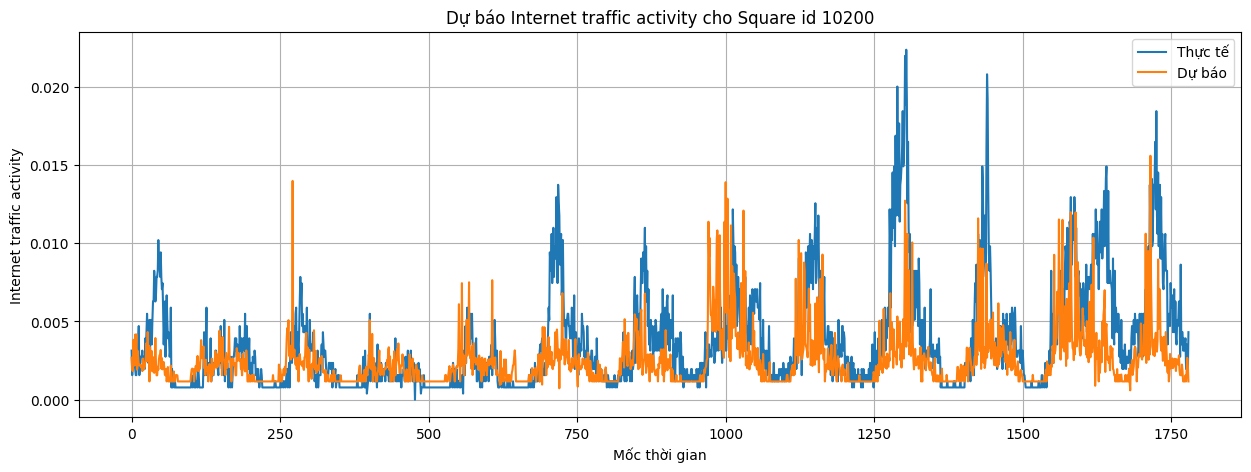

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# 1️⃣ Đọc toàn bộ file trong thư mục temporal-fusion-transformer
batch_folder = "/kaggle/input/temporal-fusion-transformer"
batch_files = [f for f in os.listdir(batch_folder) if f.endswith(".parquet")]
if not batch_files:
    raise FileNotFoundError("Không tìm thấy file parquet trong thư mục temporal-fusion-transformer!")

dfs = []
for file_name in batch_files:
    file_path = os.path.join(batch_folder, file_name)
    df_batch = pd.read_parquet(file_path)
    df_batch['Time Interval'] = pd.to_datetime(df_batch['Time Interval'], unit='ms')
    dfs.append(df_batch)

df = pd.concat(dfs, ignore_index=True)
print(f"Đã đọc {len(batch_files)} file, tổng số bản ghi: {len(df)}")

# 2️⃣ Lọc Square id = 10200
square_id = 10200
df_square = df[df['Square id'] == square_id].sort_values("Time Interval")
if df_square.empty:
    raise ValueError(f"Không tìm thấy dữ liệu cho Square id {square_id}")

print(f"Số bản ghi cho Square id {square_id}: {len(df_square)}")

# 3️⃣ Đặc trưng + target
features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity']
target = 'Internet traffic activity'

X = df_square[features].values
y = df_square[target].values

# 4️⃣ Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# 6️⃣ Huấn luyện XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 42
}

num_round = 100
model = xgb.train(params, dtrain, num_round)

# 7️⃣ Dự báo
y_pred = model.predict(dtest)

# 8️⃣ Đánh giá
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🎯 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R2  (R-squared score): {r2:.4f}")

# 9️⃣ Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(y_test, label="Thực tế")
plt.plot(y_pred, label="Dự báo")
plt.legend()
plt.title(f"Dự báo Internet traffic activity cho Square id {square_id}")
plt.xlabel("Mốc thời gian")
plt.ylabel("Internet traffic activity")
plt.grid(True)
plt.show()
